# 模拟合约对于Uni的对冲作用

In [22]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'notebook'

In [2]:
# 模拟币本位合约盈亏

# 生成价格序列
def gen_price_series(start_price, end_price, n):
    price_series = [start_price]
    interval = (end_price - start_price) / n
    for i in range(n):
        price_series.append(price_series[i] + interval)
    return price_series

# 计算盈亏
def calc_bi_pnl(open, close,direction,contract_value):
    return (1/open - 1/close) * direction * contract_value
def calc_u_pnl(open, close,direction,contract_value):
    return (close - open)/open * direction * contract_value
    

In [3]:
start_price = 20000
end_price = 40000
mid_price = (start_price + end_price) / 2

In [4]:
price = gen_price_series(start_price, end_price, 500)
price = pd.DataFrame(price, columns=['price'])
price['bi_pnl'] = price.apply(lambda x: calc_bi_pnl(mid_price, x['price'], 1, mid_price * 0.5), axis=1)
price['u_pnl'] = price.apply(lambda x: calc_u_pnl(mid_price, x['price'], -1, mid_price * 0.5), axis=1)

In [5]:
# 模仿uniswap做市的币的变动

def get_deltax(p0,p1,liq):
    a0 = liq * (1/math.sqrt(p1) - 1/math.sqrt(p0))
    return a0

def get_deltay(p0,p1,liq):
    a0 = liq * (math.sqrt(p1) - math.sqrt(p0))
    return a0

price['a0'] = price.apply(lambda x: get_deltax(mid_price, x['price'], math.sqrt(30000 * 1)), axis=1)
price['a1'] = price.apply(lambda x: get_deltay(mid_price, x['price'], math.sqrt(30000 * 1)), axis=1)
    

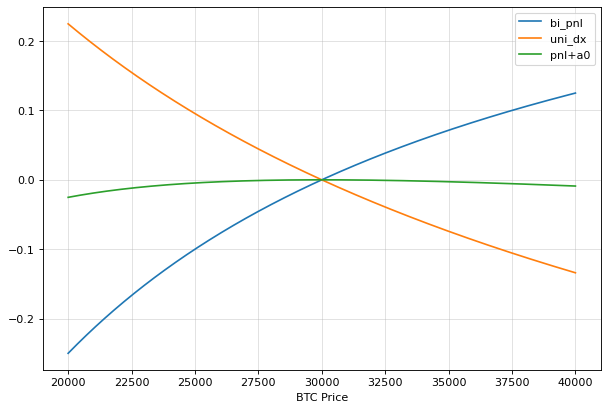

In [6]:
# 画图，横轴为price，纵轴为pnl
import matplotlib.pyplot as plt
# 设置尺寸
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(price['price'], price['bi_pnl'])
plt.plot(price['price'], price['a0'])
plt.plot(price['price'], price['bi_pnl'] + price['a0'])

# 图例
plt.legend(['bi_pnl', 'uni_dx', 'pnl+a0'])
# 网格
plt.xlabel('BTC Price')
plt.grid(alpha=0.4)
plt.show()

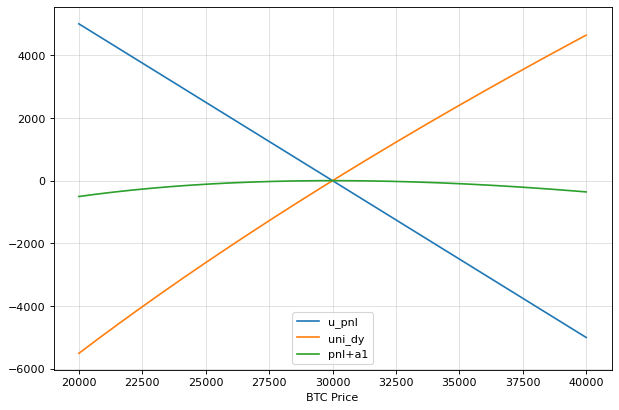

In [7]:
# 画图，横轴为price，纵轴为u_pnl,a1
# 设置尺寸
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(price['price'], price['u_pnl'])
plt.plot(price['price'], price['a1'])
plt.plot(price['price'], price['u_pnl'] + price['a1'])

# 图例
plt.legend(['u_pnl', 'uni_dy', 'pnl+a1'])
# 网格
plt.xlabel('BTC Price')

plt.grid(alpha=0.4)
plt.show()

In [48]:
import math
p2 = 2000
sigma = 0.05
p0 = p2 * (1-sigma)
p1 = p2 * (1+sigma)

q96 = 1 
a0 = 25
a1 = 50000

sqrtp0 = (math.sqrt(p0)* q96)
sqrtp1 = (math.sqrt(p1)* q96)
sqrtp2 = (math.sqrt(p2)* q96)

liq0 = a0 * (sqrtp2 * sqrtp1) / q96 / (sqrtp1 - sqrtp2)
liq1 = a1 * q96 / (sqrtp2 - sqrtp0)
liq = min(liq0, liq1)
print("liq is: ", liq)

rx = liq * q96 * (sqrtp1 - sqrtp2) / (sqrtp2 * sqrtp1)
ry = liq * (sqrtp2 - sqrtp0) / q96
print("rx is: ", rx)
print("ry is :", ry)

liq is:  44155.17449270128
rx is:  23.794815160510563
ry is : 50000.0


In [49]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# 定义函数f(p1, a)
def f(p1, a):
    # 这里定义函数f的具体表达式
    p0 = 2000
    return (1/p1**0.5 - 1/p0**0.5)*liq + (1/p0 - 1/p1) * a
# 定义方差函数

def f1(p1,a):
    p0 = 2000
    return (p1 ** 0.5 - p0 ** 0.5) * liq + (p0 - p1) * a/p0

def f_all(p1,b,c):
    p0 = 2000
    return (p1 ** 0.5 - p0 ** 0.5) * liq + (p1 - p0) * c/p1 + (1/p1**0.5 - 1/p0**0.5)*liq + (1/p0 - 1/p1) * b


def get_p1_values():
    return np.linspace(p0, p1, 100000)

def variance(b):
    # 计算f(p1, b)的方差
    p1_values = get_p1_values()
    var = np.var([f(p1, b) for p1 in p1_values])
    return var

def variance1(b):
    # 计算f(p1, b)的方差
    p1_values = get_p1_values()
    var = np.var([f1(p1, b) for p1 in p1_values])
    return var

def variance_all(x0):
    p1_values = get_p1_values()
    var = np.var([f_all(p1,x0[0],x0[1]) for p1 in p1_values])
    return var


# # 设置初始猜测值
# initial_guess_all = (10,705)
# initial_guess = 10
# # 最小化方差函数
# result = minimize(variance, initial_guess)
# result1 = minimize(variance1, initial_guess)
# result_all = minimize(variance_all, initial_guess_all)
# # 输出最小化方差的最优解
# optimal_b = result.x[0]
# print("Optimal value of b:", optimal_b)
# # 输出最小化方差的最优解
# optimal_b1 = result1.x[0]
# print("Optimal value of b1:", optimal_b1)

# # 输出最小化方差的最优解
# optimal_b_all = result_all.x[0]
# optimal_c_all = result_all.x[1]
# print("Optimal value of b_all:", optimal_b_all, "Optimal value of c_all:", optimal_c_all)
# # 杠杆倍数
# print("Optimal leverage:", optimal_b / 100000)


In [50]:
# 计算Pnl
pnl = [f(p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()]
pnl1 = [f1(p1, liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()]

In [78]:
def dy(p1,a):
    p0 = 2000
    return (p1 ** 0.5 - p0 ** 0.5) * liq

def dx(p1,a):
    p0 = 2000
    return (1/p1**0.5 - 1/p0**0.5)*liq

def upnl(p0,p1,a):
    return (p0 - p1) * a/p0

def bipnl(p0,p1,a):
    return (1/p0 - 1/p1) * a

def ushowcase(prc):
    plt.plot(get_p1_values(), [dy(p1,liq * 2000 ** 0.5 / 2) + upnl(prc,p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()])

def bishowcase(prc):
    plt.plot(get_p1_values(), [dx(p1,liq * 2000 ** 0.5 / 2) + bipnl(prc,p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()])

(1995.0, 2005.0)

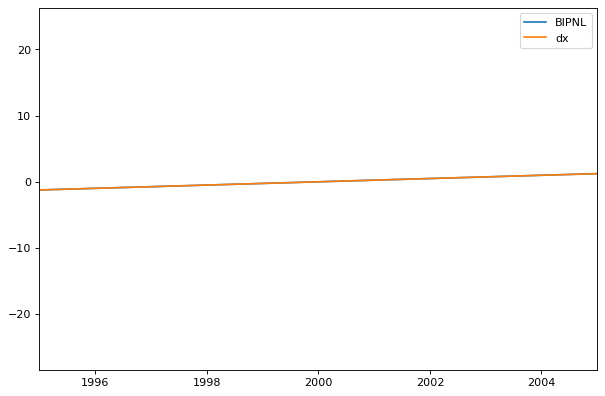

In [79]:
# 画出UPNL和BIPNL
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(get_p1_values(),[bipnl(2000,p1,liq * 2000 ** 0.5 / 2) for p1 in get_p1_values()])
plt.plot(get_p1_values(),[-dx(p1,50000) for p1 in get_p1_values()])
plt.legend(['BIPNL','dx'])
# 显示局部
plt.xlim((1995, 2005))

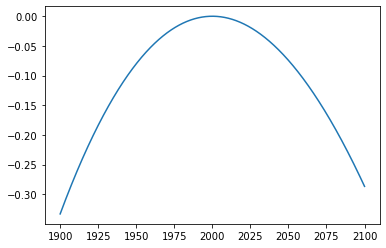

In [80]:
# 求和
plt.plot(get_p1_values(),[bipnl(2000,p1,liq * 2000 ** 0.5 / 2) + dx(p1,50000) for p1 in get_p1_values()])

调整a用直线逼近

(-1000.0, 1000.0)

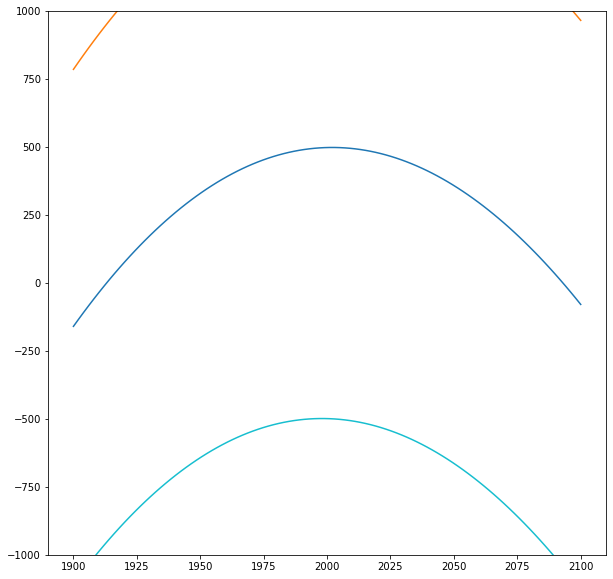

In [55]:
prc = pd.DataFrame(get_p1_values(),columns=['price'])
prc
plt.figure(figsize=(10,10))
for index,row in prc.iterrows():
    plt.plot(prc['price'], dy(prc['price'],liq * 2000 ** 0.5 / 2) + [upnl(row['price'],p1,liq * 2000 ** 0.5 / 2) for p1 in prc['price']])
    
# 只显示指定y轴区域内容
plt.ylim(-1000, 1000)

In [68]:
import pandas as pd

# 示例价格序列
price_series = [100, 102, 105, 98, 103, 99, 101, 105, 107, 110]

# 将价格序列转换为DataFrame
df = pd.DataFrame(price_series, columns=['Price'])

# 计算相对初始价格的变化（以第一行价格为基准）
initial_price = df['Price'].iloc[0]

# 定义偏移阈值（以sigma为百分比）
sigma = 0.05

df['Action'] = 1
df['change_ratio'] = 0
# 初始化持仓标志和指令列表
holding = False
orders = []

holding_flag = 1
# 遍历每一行价格数据
for i in range(1, len(df)):
    change_ratio = (df['Price'].iloc[i] - initial_price) / initial_price
    if abs(change_ratio) >= sigma:

        holding_flag = holding_flag + 1
        initial_price = df['Price'].iloc[i]

    df['Action'].iloc[i] = holding_flag
    df['change_ratio'].iloc[i] = change_ratio

# 打印指令列表
df

d:\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Price,Action,change_ratio
0,100,1,0.000000
1,102,1,0.020000
2,105,2,0.050000
3,98,3,-0.066667
4,103,4,0.051020
5,99,4,-0.038835
6,101,4,-0.019417
7,105,4,0.019417
8,107,4,0.038835
9,110,5,0.067961
